## Fourier Neural Operator 1D

In [1]:
## Imports 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import torch.nn as nn
from timeit import default_timer

c:\Users\s1612415\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Set seeds
torch.manual_seed(0)
np.random.seed(0)

## Create Data

### Ordinary Differential Equation:

\begin{align*}
m\frac{d^2x}{dt^2} = - kx
\end{align*}

Solution: 
$$x(t) = x_0 \cos{\left(\sqrt{\frac{k}{m}}t\right)} + \frac{v_0}{\sqrt{\frac{k}{m}}}\sin{\left(\sqrt{\frac{k}{m}}t\right)}$$

In [3]:
## TODO: Create Simple Harmonic Oscillator Class

In [4]:
## Simple Harmonic Oscillator
def simple_harmonic_oscillator(k: int, m: int, x0: int, v0: int, t: np.array) -> np.array:
    x = x0 * np.cos(np.sqrt(k / m) * t) + (v0 / np.sqrt(k / m)) * np.sin(np.sqrt(k / m) * t)
    return x    

In [5]:
## Number of Samples 
n = 1000
## Output
data_t = []
data_x = []

# k = np.random.randint(1, 100)
# m = np.random.randint(1, 100)
# x0 = np.random.normal(0, 10)
# v0 = np.random.normal(0, 10)
# k = 1
# m = 1000
# x0 = 1
# v0 = 1

t = np.linspace(0, 100, 100)

## Generate Data
for _ in range(n):
    k = np.random.randint(1, 10)
    k_vec = k * np.ones(100)
    m = np.random.randint(100, 1000)
    m_vec = m * np.ones(100)
    x0 = np.random.normal(0, 10)
    x0_vec = x0 * np.ones(100)
    v0 = np.random.normal(0, 1)
    v0_vec = v0 * np.ones(100)
    
    data_t.append([k_vec, m_vec, x0_vec, v0_vec, t])
    # data_x.append(simple_harmonic_oscillator(k, m, x0, v0, t))

In [6]:
## Plot
# plt.scatter(data_t, data_x, alpha=0.5)
# plt.show()

In [7]:
data_t = torch.tensor(data_t, requires_grad=True).float()
# data_x = np.array(torch.tensor(data_x).float().unsqueeze(1))

C:\Users\s1612415\AppData\Local\Temp\ipykernel_17684\1240523911.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  data_t = torch.tensor(data_t, requires_grad=True).float()


In [8]:
## Data Loader
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, t): # , x):
        self.t = t
        # self.x = x

    def __len__(self):
        return len(self.t)
    
    def __getitem__(self, index):
        return self.t[index] # , self.x[index]

data = CustomDataset(data_t) # , data_x)

In [9]:
data[0]

tensor([[  6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
           6.0000,   6.0000,   6.0000,   6.0000,   6

In [10]:
data[0].shape

torch.Size([5, 100])

In [11]:
dataloader = DataLoader(data, batch_size=64, shuffle=True)

In [12]:
next(iter(dataloader)).shape

torch.Size([64, 5, 100])

## Build Network

In [13]:
## Get Device for Training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device.')

Using cpu device.


In [14]:
## Fourier Integral Kernel 1D
class FourierIntegralKernel1D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super(FourierIntegralKernel1D, self).__init__()
        '''
        '''
        self.in_channels = in_channels
        self.out_channels = out_channels 
        self.modes = modes 
        ## Set (random) weights for the linear transform
        weights = torch.rand(self.modes, self.out_channels, self.in_channels, dtype=torch.cfloat) 
        self.weights = nn.Parameter(weights / (self.in_channels * self.out_channels)) ## Optional: Scale weights

    def forward(self, v: torch.Tensor) -> torch.Tensor:
        '''
        FFT -> Linear Transform -> Inverse FFT
        '''
        ## FFT
        v_rfft = torch.fft.rfft(v) 

        ## Linear Transform 
        lv_rfft = torch.zeros(v_rfft.shape, dtype=torch.cfloat)
        lv_rfft[:, :, :self.modes] = torch.einsum('koi, bki -> bko', self.weights, v_rfft[:, :, :self.modes].permute(0, 2, 1)).permute(0, 2, 1) ## TODO: Should I have 5 dimensions here?
        
        ## Inverse FFT
        v2 = torch.fft.irfft(lv_rfft, n=v.shape[-1])
        return v2
        

In [15]:
## Fourier Network Operator 1D
class FourierNetworkOperator1D(nn.Module):
    def __init__(self, da: int, du: int, width: int, modes: int):
        super(FourierNetworkOperator1D, self).__init__()
        '''
        '''
        self.width = width
        self.modes = modes

        ## P: Lifts the lower dimensional function to higher dimensional space
        self.P = nn.Conv1d(da, self.width, 1) ## TODO: Change da

        ## K: Fourier integral kernel operator
        self.k0 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k1 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k2 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k3 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k4 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k5 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k6 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k7 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k8 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k9 = FourierIntegralKernel1D(self.width, self.width, self.modes)

        ## W: Pointwise linear operator
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.w5 = nn.Conv1d(self.width, self.width, 1)
        self.w6 = nn.Conv1d(self.width, self.width, 1)
        self.w7 = nn.Conv1d(self.width, self.width, 1)
        self.w8 = nn.Conv1d(self.width, self.width, 1)
        self.w9 = nn.Conv1d(self.width, self.width, 1)

        ## Q: Projects the higher dimensional function to lower dimensional space
        self.Q = nn.Conv1d(self.width, du, 1) ## TODO: Change du

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        '''
        ## P
        x = self.P(x)

        ## Fourier Layer #0
        ## K
        x1 = self.k0(x)
        ## W
        x2 = self.w0(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #1
        ## K
        x1 = self.k1(x)
        ## W
        x2 = self.w1(x)
        ## Sum 
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #2
        ## K
        x1 = self.k2(x)
        ## W
        x2 = self.w2(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #3
        ## K
        x1 = self.k3(x)
        ## W
        x2 = self.w3(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #4
        ## K
        x1 = self.k4(x)
        ## W
        x2 = self.w4(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #5
        ## K
        x1 = self.k5(x)
        ## W
        x2 = self.w5(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #6
        ## K
        x1 = self.k6(x)
        ## W
        x2 = self.w6(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #7
        ## K
        x1 = self.k7(x)
        ## W
        x2 = self.w7(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #8
        ## K
        x1 = self.k8(x)
        ## W
        x2 = self.w8(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #9
        ## K
        x1 = self.k9(x)
        ## W
        x2 = self.w9(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Q
        x = self.Q(x)
        return x


In [16]:
import operator
from functools import reduce

def count_parameters(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size() + (2, ) if p.is_complex() else p.size()))
    return c

model = FourierNetworkOperator1D(5, 1, width=64, modes=8)
print(f'Number of parameters: {count_parameters(model)}')

Number of parameters: 697409


## Train

In [17]:
## Model Parameters
learning_rate = 1e-3
epochs = 5

In [18]:
class PDELoss(nn.Module):
    def __init__(self):
        super(PDELoss, self).__init__()

    def forward(self, m, dxdt2, k, model_output):
        return torch.mean(torch.mean(torch.square(m * dxdt2 + k * model_output.squeeze()), 1, keepdim=True), 0)

loss_function = PDELoss()

In [19]:
## Loss Function
# loss_function = nn.MSELoss()

In [20]:
## Optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

k: 6
m: 917
x0: -5.888131995338436
v0: -0.16615313560795222


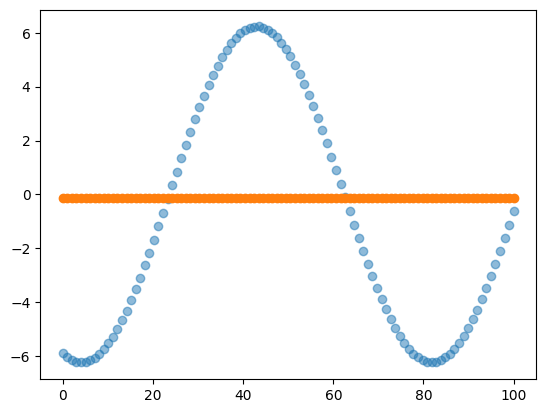

In [21]:
## Test 0
k0 = np.random.randint(1, 10)
print(f'k: {k0}')
k0_vec = torch.from_numpy(k0 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

m0 = np.random.randint(100, 1000)
print(f'm: {m0}')
m0_vec = torch.from_numpy(m0 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

x00 = np.random.normal(0, 10)
print(f'x0: {x00}')
x00_vec = torch.from_numpy(x00 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

v00 = np.random.normal(0, 1)
print(f'v0: {v00}')
v00_vec = torch.from_numpy(v00 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

t_test = torch.from_numpy(np.linspace(0, 100, 100)).float().unsqueeze(0).unsqueeze(0)
x0_test = simple_harmonic_oscillator(k0, m0, x00, v00, t_test)


plt.scatter(t_test, x0_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((k0_vec, m0_vec, x00_vec, v00_vec, t_test), 1)).detach())
plt.show()

k: 2
m: 953
x0: -7.0665916119712735
v0: -0.5844875170982337


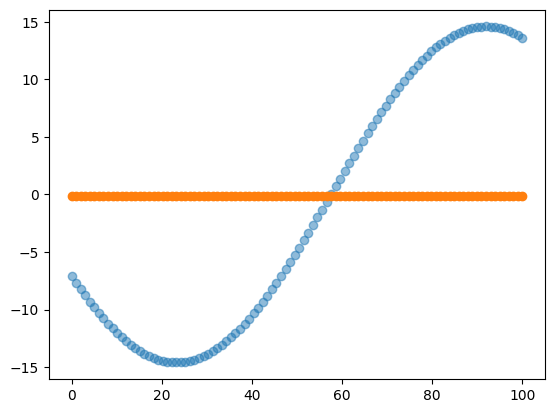

In [22]:
## Test 1
k1 = np.random.randint(1, 10)
print(f'k: {k1}')
k1_vec = torch.from_numpy(k1 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

m1 = np.random.randint(100, 1000)
print(f'm: {m1}')
m1_vec = torch.from_numpy(m1 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

x01 = np.random.normal(0, 10)
print(f'x0: {x01}')
x01_vec = torch.from_numpy(x01 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

v01 = np.random.normal(0, 1)
print(f'v0: {v01}')
v01_vec = torch.from_numpy(v01 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

t_test = torch.from_numpy(np.linspace(0, 100, 100)).float().unsqueeze(0).unsqueeze(0)
x1_test = simple_harmonic_oscillator(k1, m1, x01, v01, t_test)


plt.scatter(t_test, x1_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((k1_vec, m1_vec, x01_vec, v01_vec, t_test), 1)).detach())
plt.show()

k: 4
m: 171
x0: -3.3023789326454427
v0: -0.8348071635345082


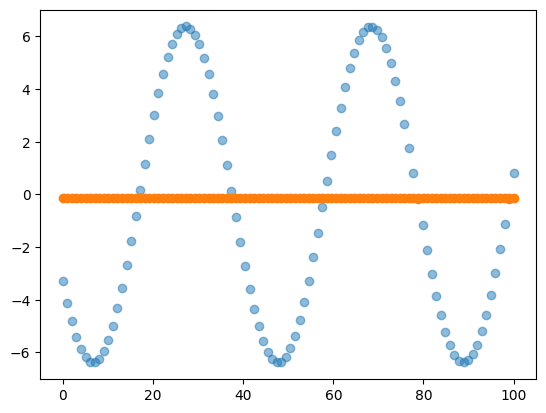

In [23]:
## Test 2
k2 = np.random.randint(1, 10)
print(f'k: {k2}')
k2_vec = torch.from_numpy(k2 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

m2 = np.random.randint(100, 1000)
print(f'm: {m2}')
m2_vec = torch.from_numpy(m2 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

x02 = np.random.normal(0, 10)
print(f'x0: {x02}')
x02_vec = torch.from_numpy(x02 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

v02 = np.random.normal(0, 1)
print(f'v0: {v02}')
v02_vec = torch.from_numpy(v02 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

t_test = torch.from_numpy(np.linspace(0, 100, 100)).float().unsqueeze(0).unsqueeze(0)
x2_test = simple_harmonic_oscillator(k2, m2, x02, v02, t_test)


plt.scatter(t_test, x2_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((k2_vec, m2_vec, x02_vec, v02_vec, t_test), 1)).detach())
plt.show()

In [29]:
## Training Loop
def train_loop(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    for batch, t in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(t)

        m = t[:, 1, :]
        k = t[:, 0, :]

        dxdt1 = torch.autograd.grad(pred, t, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(pred))[0]
        dxdt2  = torch.autograd.grad(dxdt1, t, grad_outputs=torch.ones_like(dxdt1))[0]
        loss = loss_function(m, dxdt2[:, 4, :], k, pred)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(t)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [30]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader, model, loss_function, optimizer)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

## Test

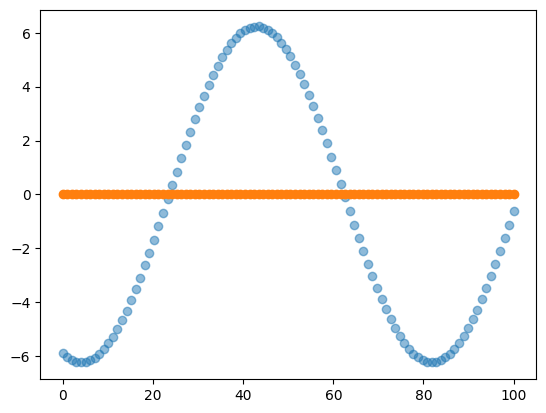

In [26]:
## Test 0
plt.scatter(t_test, x0_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((k0_vec, m0_vec, x00_vec, v00_vec, t_test), 1)).detach())
plt.show()

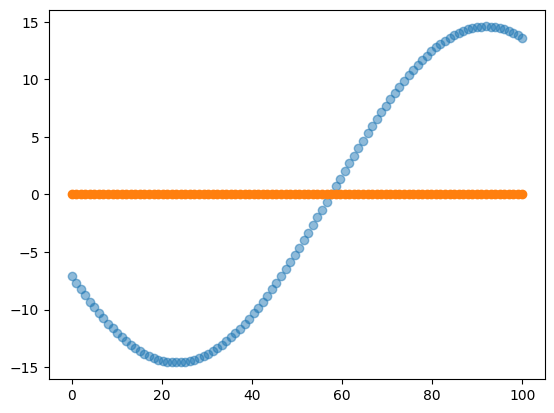

In [27]:
## Test 1
plt.scatter(t_test, x1_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((k1_vec, m1_vec, x01_vec, v01_vec, t_test), 1)).detach())
plt.show()

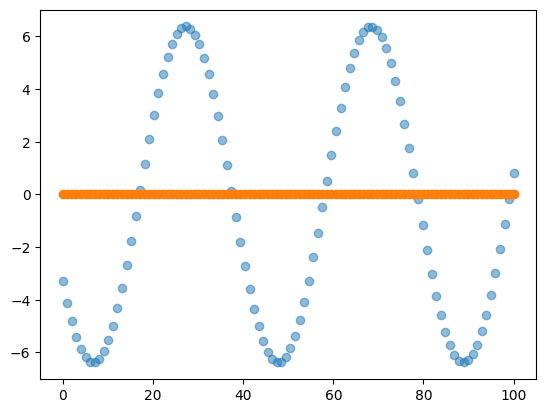

In [28]:
## Test 2
plt.scatter(t_test, x2_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((k2_vec, m2_vec, x02_vec, v02_vec, t_test), 1)).detach())
plt.show()